In [13]:
import numpy               as np
import pandas              as pd
import h5py                as h5py
import matplotlib.pyplot   as plt
import torch
import torch.nn            as nn
import torch.nn.functional as F
import pickle

import os.path
#from   os              import path
from   IPython.display import clear_output
from   numpy.random    import seed
from   sklearn.utils   import shuffle

np.set_printoptions(precision = 5)

devCPU = torch.device("cpu")
dev    = devCPU

#from torch.utils.tensorboard import SummaryWriter  # to print to tensorboard
from torch.utils.data import DataLoader, Dataset

plt.rcParams["figure.figsize"] = (6,4)
plt.rcParams["figure.dpi"]     = 200

In [14]:
def scale_sequence(x,scale):
    return scale*(1.-2.*x)

def truncate_normalize_free_energy(y):
    norm    = np.max(np.abs(y))
    print ("F-norm = ",norm)
    #ynorm   = y / norm
    ynorm = y
    norm = 1.
    return ynorm,norm

def preprocess(x,y,sequenceScale):
    x       = scale_sequence(x,sequenceScale)
    y, norm = truncate_normalize_free_energy(y)
    return x,y,norm

def iterate_batch(x,y,batchSize):
    for i in range(0, x.shape[0], batchSize):
        yield (x[i:i + batchSize], y[i:i + batchSize])

def init_weights(m):
    if isinstance(m, nn.Linear):
        n     =  m.in_features
        width = .5 * np.min ( ( np.sqrt ( 20./ n ) , 1.) )
        m.weight.data.uniform_( -width, width ) 
        # selecting the initial weigths from uniform distributions

In [15]:
file = '../../../Hdf_files_Row_as_Sequence/Sca_Ext_Abs_N12.hdf5'
N='/N12/'
opt='Sca/'
direc='Long/'

Input = np.linspace(1.13,3.53,81)

col='output1'
Sca_Output_Col_2 = pd.read_hdf(file, N+opt+direc+col)

col='input'
Sca_Sequence = pd.read_hdf(file ,N+opt+direc+col)

opt='Sca/'
direc='Trans/'
col='output1'
Sca_Output_Col_3 = pd.read_hdf(file, N+opt+direc+col)

opt='Ext/'
col='output1'
direc='Long/'
Sca_Output_Col_4 = pd.read_hdf(file, N+opt+direc+col)

opt='Ext/'
col='output1'
direc='Trans/'
Sca_Output_Col_5 = pd.read_hdf(file, N+opt+direc+col)

opt='Abs/'
col='output1'
direc='Long/'
Sca_Output_Col_6 = pd.read_hdf(file, N+opt+direc+col)

opt='Abs/'
col='output1'
direc='Trans/'
Sca_Output_Col_7 = pd.read_hdf(file, N+opt+direc+col)

sequenceScale = 0.7
X1f = Sca_Sequence.to_numpy()
Y1f_1 = Sca_Output_Col_2.to_numpy()
Y1f_2 = Sca_Output_Col_3.to_numpy()
Y1f_3 = Sca_Output_Col_4.to_numpy()
Y1f_4 = Sca_Output_Col_5.to_numpy()
Y1f_5 = Sca_Output_Col_6.to_numpy()
Y1f_6 = Sca_Output_Col_7.to_numpy()

Y1f_N10 = np.concatenate((Y1f_1, Y1f_2, Y1f_3, Y1f_4, Y1f_5), axis=1)

X1f = X1f[:300,:]

print(X1f.shape)
print(Y1f_N10.shape)

X1_N10, Y1_N10, Y1norm_N10 = preprocess(X1f, Y1f_N10, sequenceScale)

shuffleIdx= shuffle(np.arange(X1_N10.shape[0]))
X1_N10    = X1_N10[shuffleIdx]
Y1_N10    = Y1_N10[shuffleIdx]


INDEX = 50

X1_TRAIN_N10 = X1_N10[:INDEX][:]
Y1_TRAIN_N10 = Y1_N10[:INDEX][:]

X1_Train = torch.from_numpy(X1_TRAIN_N10).float()
Y1_Train = torch.from_numpy(Y1_TRAIN_N10).float()

print(X1_Train.shape, Y1_Train.shape)

X1_TEST_N10 = X1_N10[INDEX:][:]
Y1_TEST_N10 = Y1_N10[INDEX:][:]

X1_Test_10 = torch.from_numpy(X1_TEST_N10).float()
Y1_Test_10 = torch.from_numpy(Y1_TEST_N10).float()
print(X1_Test_10.shape, Y1_Test_10.shape)

(300, 12)
(300, 405)
F-norm =  439900.0
torch.Size([50, 12]) torch.Size([50, 405])
torch.Size([250, 12]) torch.Size([250, 405])


In [16]:
class XY_Data(Dataset):
    def __init__(self, X, Y):
        #data loading
        self.input   = X
        self.output  = Y
        self.n_samples = X.shape[0]
        
    def __getitem__(self, index):
        # dataset[0]
        return self.input[index], self.output[index]
        
    def __len__(self):
        # len(dataset)
        return self.n_samples
    
TrainDataset = XY_Data(X1_Train, Y1_Train)

In [17]:
batch_size = 12

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=TrainDataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

In [18]:
# Hyper-parameters

hidden_size     = 128
num_layers      = 2

num_classes     = Y1_Train.shape[1]
num_epochs      = 15000
learning_rate   = 0.1
l2              = 1e-5
input_size      = 1
sequence_length = X1_Train.shape[1]
device          = dev

In [19]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(RNN, self).__init__()
        
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        
        ## x-> (batchsize, seq, input_size)
        self.gru = nn.GRU(input_size, hidden_size, num_layers, bias=False, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, num_classes, bias=False)
         
    def forward(self, x):
        
        h0 = torch.zeros(self.num_layers, x.shape[0], self.hidden_size).to(device)
        
        out, h_n = self.gru(x, h0)
        ## out -> (batchsize, seq_length =1, hidden_size)
        ## h_n -> (num_layer, N, hidden_size)
        
        out = out[:, -1, :]
        ## out (batchsize, hidden_size)
        
        out = self.fc(out)
        
        return out

In [20]:
model = RNN(input_size, hidden_size, num_layers, num_classes)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay = l2)

# Train the model
n_total_steps = len(train_loader)
print(len(train_loader))

mseHistory = list() # loss history

xTrain = X1_Train 
yTrain = Y1_Train 

5


In [21]:
for epoch in range(num_epochs):
    
    
    with torch.no_grad():
            if ( epoch % 10 == 0 ):
                
                xTrain   = xTrain.reshape(-1, sequence_length, input_size).to(device)
                yPred    = model(xTrain)
                M        = yTrain.shape[0]*yTrain.shape[1]
                mseTrain = (yPred - yTrain).pow(2).sum()/M
                
                
                xTest     = X1_Test_10
                yTest     = Y1_Test_10
                xTest     = xTest.reshape(-1, sequence_length, input_size).to(device)
                yPred     = model(xTest)
                M         = yTest.shape[0]*yTest.shape[1]
                mseTest_10 = (yPred -  yTest).pow(2).sum()/M # mean square
                
                
                mseRecord= np.array ( (epoch, float(mseTrain), float(mseTest_10) ))
                
                print ( "rmse/kT ~", mseRecord[0], np.sqrt(mseRecord[1:] ))
                mseHistory.append(mseRecord)
                
                if ( epoch% 500 == 0 ):
                    
                    print(xTest.shape)
                    print(yTest.shape)
                    print(yPred.shape)
                
                    np_yPred = yPred.cpu().detach().numpy()
                    yPred_DF =pd.DataFrame(np_yPred)
                
                    np_yTest = yTest.cpu().detach().numpy()
                    yTest_DF =pd.DataFrame(np_yTest)
                    
                    xTest = xTest.squeeze(2)
                    
                    np_xTest = xTest.cpu().detach().numpy()
                    xTest_DF =pd.DataFrame(np_xTest)
                    
                    fname_1 = './GRU_Individual_SeqProp.hdf5'
                    path_1 = '/N12/test/sample50/'
                
                    yPred_DF.to_hdf(fname_1, path_1+'Pred'+str(epoch),mode='a')
                
                    yTest_DF.to_hdf(fname_1, path_1+'Target'+str(epoch),mode='a')
                    
                    xTest_DF.to_hdf(fname_1, path_1+'Sequence'+str(epoch),mode='a')
                    
                
    for i, (images, labels) in enumerate(train_loader):  
        
        images = images.reshape(-1, sequence_length, input_size)
    
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

rmse/kT ~ 0.0 [129339.69711 129326.20956]
torch.Size([250, 12, 1])
torch.Size([250, 405])
torch.Size([250, 405])
rmse/kT ~ 10.0 [128941.57288 128927.70613]
rmse/kT ~ 20.0 [128499.09895 128484.79393]
rmse/kT ~ 30.0 [128062.06895 128047.34324]
rmse/kT ~ 40.0 [127630.7153  127615.54664]
rmse/kT ~ 50.0 [127204.17402 127188.56804]
rmse/kT ~ 60.0 [126781.48811 126765.44236]
rmse/kT ~ 70.0 [126361.84538 126345.36946]
rmse/kT ~ 80.0 [125946.22344 125929.33536]
rmse/kT ~ 90.0 [125532.35784 125515.02654]
rmse/kT ~ 100.0 [125121.95599 125104.19133]
rmse/kT ~ 110.0 [124714.58821 124696.40829]
rmse/kT ~ 120.0 [124309.60471 124290.99893]
rmse/kT ~ 130.0 [123906.14048 123887.08149]
rmse/kT ~ 140.0 [123505.18875 123485.66155]
rmse/kT ~ 150.0 [123106.57861 123086.6138 ]
rmse/kT ~ 160.0 [122710.75845 122690.36617]
rmse/kT ~ 170.0 [122316.27777 122295.43036]
rmse/kT ~ 180.0 [121924.06082 121902.75154]
rmse/kT ~ 190.0 [121534.42442 121512.68023]
rmse/kT ~ 200.0 [121146.48059 121124.28209]
rmse/kT ~ 210.0 

rmse/kT ~ 1830.0 [74171.43385 74041.53818]
rmse/kT ~ 1840.0 [73947.9947  73817.10588]
rmse/kT ~ 1850.0 [73727.36458 73595.99989]
rmse/kT ~ 1860.0 [73506.36479 73374.34625]
rmse/kT ~ 1870.0 [73285.28191 73152.30446]
rmse/kT ~ 1880.0 [73065.37653 72931.69626]
rmse/kT ~ 1890.0 [72846.54688 72712.13687]
rmse/kT ~ 1900.0 [72626.5644  72491.00137]
rmse/kT ~ 1910.0 [72407.35963 72270.88244]
rmse/kT ~ 1920.0 [72189.65954 72052.56392]
rmse/kT ~ 1930.0 [71972.82687 71835.09649]
rmse/kT ~ 1940.0 [71755.91694 71617.294  ]
rmse/kT ~ 1950.0 [71539.26899 71399.5442 ]
rmse/kT ~ 1960.0 [71323.20486 71182.59922]
rmse/kT ~ 1970.0 [71108.15469 70966.74421]
rmse/kT ~ 1980.0 [70893.94716 70751.92763]
rmse/kT ~ 1990.0 [70679.14114 70535.88341]
rmse/kT ~ 2000.0 [70465.2207  70320.96655]
torch.Size([250, 12, 1])
torch.Size([250, 405])
torch.Size([250, 405])
rmse/kT ~ 2010.0 [70252.59841 70107.51606]
rmse/kT ~ 2020.0 [70040.48932 69894.73594]
rmse/kT ~ 2030.0 [69828.52048 69681.88654]
rmse/kT ~ 2040.0 [69617.65

rmse/kT ~ 3680.0 [39996.87508 39734.01002]
rmse/kT ~ 3690.0 [39842.53325 39579.58747]
rmse/kT ~ 3700.0 [39687.73473 39423.58117]
rmse/kT ~ 3710.0 [39533.58795 39268.48222]
rmse/kT ~ 3720.0 [39379.42935 39113.65511]
rmse/kT ~ 3730.0 [39225.61775 38958.88951]
rmse/kT ~ 3740.0 [39072.00655 38805.2516 ]
rmse/kT ~ 3750.0 [38919.40555 38652.7747 ]
rmse/kT ~ 3760.0 [38767.63681 38501.69368]
rmse/kT ~ 3770.0 [38614.43958 38348.23511]
rmse/kT ~ 3780.0 [38462.03988 38195.21897]
rmse/kT ~ 3790.0 [38310.61931 38044.44054]
rmse/kT ~ 3800.0 [38159.15471 37892.64161]
rmse/kT ~ 3810.0 [38007.61187 37740.02183]
rmse/kT ~ 3820.0 [37856.44632 37588.22965]
rmse/kT ~ 3830.0 [37706.0479  37438.00849]
rmse/kT ~ 3840.0 [37555.6743  37286.80625]
rmse/kT ~ 3850.0 [37406.14709 37137.34078]
rmse/kT ~ 3860.0 [37257.26174 36988.93586]
rmse/kT ~ 3870.0 [37108.29816 36838.43558]
rmse/kT ~ 3880.0 [36959.16882 36687.68774]
rmse/kT ~ 3890.0 [36810.43504 36538.02753]
rmse/kT ~ 3900.0 [36662.11211 36389.01461]
rmse/kT ~ 3

rmse/kT ~ 5520.0 [28490.5677  28844.24046]
rmse/kT ~ 5530.0 [28375.63236 28729.89913]
rmse/kT ~ 5540.0 [28261.17506 28616.10847]
rmse/kT ~ 5550.0 [28146.33191 28502.53041]
rmse/kT ~ 5560.0 [28032.22374 28389.66009]
rmse/kT ~ 5570.0 [27918.19364 28276.28264]
rmse/kT ~ 5580.0 [27804.6845  28162.84645]
rmse/kT ~ 5590.0 [27692.28051 28052.32825]
rmse/kT ~ 5600.0 [27579.85352 27942.47348]
rmse/kT ~ 5610.0 [27468.01019 27831.34233]
rmse/kT ~ 5620.0 [27356.66178 27720.35671]
rmse/kT ~ 5630.0 [27246.48264 27612.02637]
rmse/kT ~ 5640.0 [27134.28886 27500.69555]
rmse/kT ~ 5650.0 [27024.3055  27391.20209]
rmse/kT ~ 5660.0 [26913.89411 27282.68139]
rmse/kT ~ 5670.0 [26803.67497 27173.42231]
rmse/kT ~ 5680.0 [26693.49224 27064.27904]
rmse/kT ~ 5690.0 [26584.04815 26955.51892]
rmse/kT ~ 5700.0 [26474.48644 26847.02263]
rmse/kT ~ 5710.0 [26364.89909 26736.98741]
rmse/kT ~ 5720.0 [26255.25288 26627.01185]
rmse/kT ~ 5730.0 [26147.96665 26519.75264]
rmse/kT ~ 5740.0 [26039.33763 26411.13583]
rmse/kT ~ 5

rmse/kT ~ 7380.0 [13476.87738 13427.59964]
rmse/kT ~ 7390.0 [13434.77041 13384.9916 ]
rmse/kT ~ 7400.0 [13393.08896 13346.39906]
rmse/kT ~ 7410.0 [13352.50209 13303.71196]
rmse/kT ~ 7420.0 [13313.26556 13263.19479]
rmse/kT ~ 7430.0 [13274.62602 13226.10993]
rmse/kT ~ 7440.0 [13235.68993 13189.04636]
rmse/kT ~ 7450.0 [13197.13666 13150.93487]
rmse/kT ~ 7460.0 [13159.44376 13113.16407]
rmse/kT ~ 7470.0 [13122.48025 13076.4668 ]
rmse/kT ~ 7480.0 [13086.1374  13042.03788]
rmse/kT ~ 7490.0 [13049.65471 13005.61417]
rmse/kT ~ 7500.0 [13013.85846 12970.52042]
torch.Size([250, 12, 1])
torch.Size([250, 405])
torch.Size([250, 405])
rmse/kT ~ 7510.0 [12978.14594 12937.06675]
rmse/kT ~ 7520.0 [12943.54635 12901.53417]
rmse/kT ~ 7530.0 [12910.74529 12866.90701]
rmse/kT ~ 7540.0 [12877.89424 12836.76408]
rmse/kT ~ 7550.0 [12845.3042  12807.23171]
rmse/kT ~ 7560.0 [12812.96531 12779.00841]
rmse/kT ~ 7570.0 [12781.18805 12749.50038]
rmse/kT ~ 7580.0 [12750.34117 12716.73543]
rmse/kT ~ 7590.0 [12720.26

rmse/kT ~ 9220.0 [11264.832   11350.09533]
rmse/kT ~ 9230.0 [11263.12177 11347.46351]
rmse/kT ~ 9240.0 [11261.19816 11347.93655]
rmse/kT ~ 9250.0 [11259.4245  11347.93232]
rmse/kT ~ 9260.0 [11257.27818 11347.7663 ]
rmse/kT ~ 9270.0 [11255.43993 11344.35049]
rmse/kT ~ 9280.0 [11253.72543 11342.10809]
rmse/kT ~ 9290.0 [11252.03733 11342.83809]
rmse/kT ~ 9300.0 [11250.33902 11344.27785]
rmse/kT ~ 9310.0 [11248.61165 11345.44631]
rmse/kT ~ 9320.0 [11246.82035 11347.98273]
rmse/kT ~ 9330.0 [11244.94909 11343.98166]
rmse/kT ~ 9340.0 [11243.20702 11343.05567]
rmse/kT ~ 9350.0 [11241.52588 11342.76122]
rmse/kT ~ 9360.0 [11239.72491 11337.93173]
rmse/kT ~ 9370.0 [11238.08738 11338.95233]
rmse/kT ~ 9380.0 [11236.22178 11335.9686 ]
rmse/kT ~ 9390.0 [11234.47836 11333.8403 ]
rmse/kT ~ 9400.0 [11232.81443 11334.5786 ]
rmse/kT ~ 9410.0 [11230.81867 11332.63323]
rmse/kT ~ 9420.0 [11228.97395 11334.64565]
rmse/kT ~ 9430.0 [11227.07905 11334.08699]
rmse/kT ~ 9440.0 [11225.64778 11333.97053]
rmse/kT ~ 9

rmse/kT ~ 11040.0 [11543.00758 11505.2774 ]
rmse/kT ~ 11050.0 [11540.48353 11502.10172]
rmse/kT ~ 11060.0 [11538.26885 11500.75406]
rmse/kT ~ 11070.0 [11536.09535 11497.33082]
rmse/kT ~ 11080.0 [11533.92908 11494.08648]
rmse/kT ~ 11090.0 [11531.35378 11492.36581]
rmse/kT ~ 11100.0 [11528.99336 11490.56587]
rmse/kT ~ 11110.0 [11527.04264 11487.95926]
rmse/kT ~ 11120.0 [11524.227   11488.73535]
rmse/kT ~ 11130.0 [11522.08071 11487.10373]
rmse/kT ~ 11140.0 [11519.79791 11488.76425]
rmse/kT ~ 11150.0 [11517.47542 11490.18851]
rmse/kT ~ 11160.0 [11515.19518 11487.35618]
rmse/kT ~ 11170.0 [11513.04582 11488.59469]
rmse/kT ~ 11180.0 [11511.05139 11489.17438]
rmse/kT ~ 11190.0 [11508.69689 11484.65167]
rmse/kT ~ 11200.0 [11506.42707 11483.00448]
rmse/kT ~ 11210.0 [11504.22914 11485.36042]
rmse/kT ~ 11220.0 [11505.67095 11472.50034]
rmse/kT ~ 11230.0 [11510.71501 11489.51313]
rmse/kT ~ 11240.0 [11508.56794 11487.14586]
rmse/kT ~ 11250.0 [11506.45767 11484.96582]
rmse/kT ~ 11260.0 [11504.33727 1

rmse/kT ~ 12860.0 [10946.95684 11064.57627]
rmse/kT ~ 12870.0 [10941.22735 11060.58262]
rmse/kT ~ 12880.0 [10935.71031 11056.26375]
rmse/kT ~ 12890.0 [10930.78588 11051.76402]
rmse/kT ~ 12900.0 [10926.66646 11050.24995]
rmse/kT ~ 12910.0 [10922.89559 11048.26357]
rmse/kT ~ 12920.0 [10917.80527 11045.05536]
rmse/kT ~ 12930.0 [10913.38041 11042.06756]
rmse/kT ~ 12940.0 [10910.06324 11041.60242]
rmse/kT ~ 12950.0 [10904.74502 11034.27786]
rmse/kT ~ 12960.0 [10901.09829 11033.87004]
rmse/kT ~ 12970.0 [10897.03776 11030.07489]
rmse/kT ~ 12980.0 [10844.40058 10976.65632]
rmse/kT ~ 12990.0 [10839.85314 10977.78703]
rmse/kT ~ 13000.0 [10835.26317 10973.11296]
torch.Size([250, 12, 1])
torch.Size([250, 405])
torch.Size([250, 405])
rmse/kT ~ 13010.0 [10830.91132 10964.95946]
rmse/kT ~ 13020.0 [10826.72582 10966.93904]
rmse/kT ~ 13030.0 [10822.749   10958.70941]
rmse/kT ~ 13040.0 [10930.48508 11089.69504]
rmse/kT ~ 13050.0 [11042.44611 11253.19723]
rmse/kT ~ 13060.0 [10804.67714 11060.42965]
rmse/

rmse/kT ~ 14660.0 [10931.76692 11244.95229]
rmse/kT ~ 14670.0 [10914.27469 11228.41004]
rmse/kT ~ 14680.0 [10898.10149 11212.18195]
rmse/kT ~ 14690.0 [10885.50706 11200.99638]
rmse/kT ~ 14700.0 [10868.36473 11182.75601]
rmse/kT ~ 14710.0 [10855.23726 11167.90831]
rmse/kT ~ 14720.0 [10845.92421 11159.63225]
rmse/kT ~ 14730.0 [10836.12588 11147.55435]
rmse/kT ~ 14740.0 [10828.33801 11140.33859]
rmse/kT ~ 14750.0 [11256.09382 11598.35506]
rmse/kT ~ 14760.0 [11145.63664 11402.59339]
rmse/kT ~ 14770.0 [11096.8172  11357.28982]
rmse/kT ~ 14780.0 [11057.28466 11320.90526]
rmse/kT ~ 14790.0 [11024.47822 11290.71335]
rmse/kT ~ 14800.0 [10995.12983 11261.95578]
rmse/kT ~ 14810.0 [10970.67035 11240.08576]
rmse/kT ~ 14820.0 [10948.27913 11220.06845]
rmse/kT ~ 14830.0 [10926.25059 11198.98995]
rmse/kT ~ 14840.0 [10910.93177 11186.35991]
rmse/kT ~ 14850.0 [10896.7419  11174.06819]
rmse/kT ~ 14860.0 [10883.17196 11159.45805]
rmse/kT ~ 14870.0 [10869.57037 11148.22641]
rmse/kT ~ 14880.0 [10857.09611 1

In [22]:
DF_msehist =  pd.DataFrame(mseHistory)

fname_2 = './GRU_Individual_mse.hdf5'
path_2 = '/N12/test/sample50/msehist/'
DF_msehist.to_hdf(fname_2, path_2, mode='a')

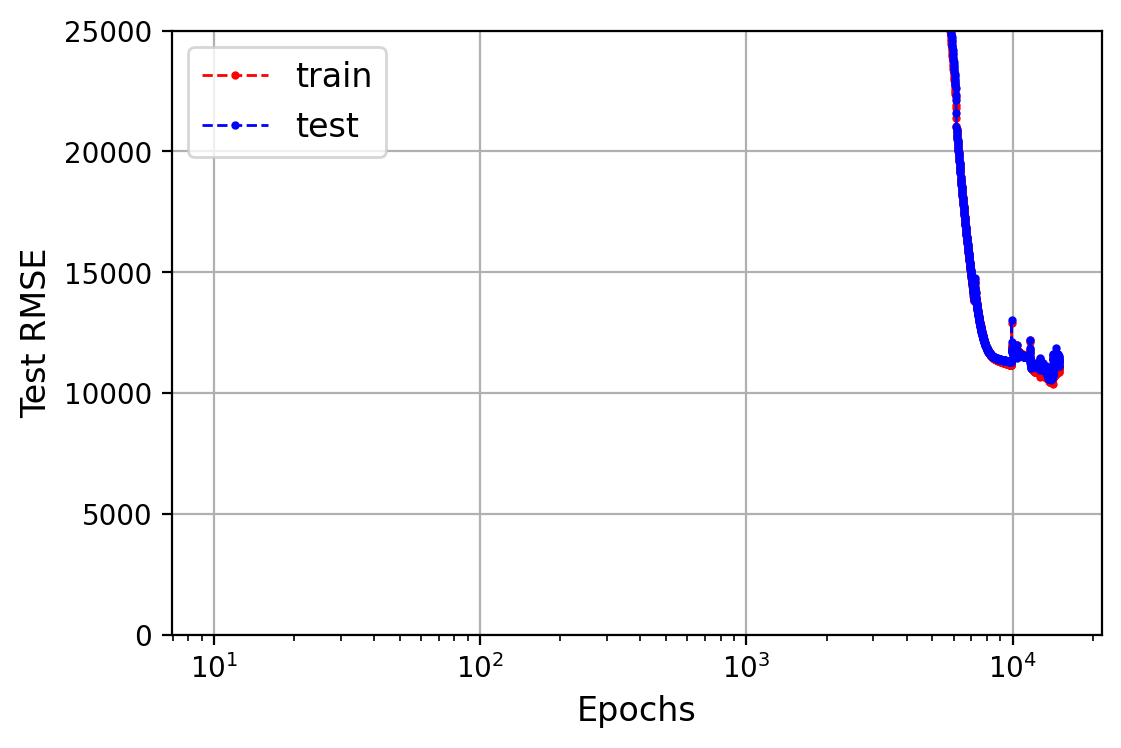

In [23]:
norm = 1.

case_N8 = DF_msehist


case_N8.columns = ['epoch', 'train_mse', 'T_8',]

plt.figure(1)
plt.xscale("log")
plt.ylim(0.0, 25000) 
plt.ylabel("Test RMSE", fontsize = 12)
plt.xlabel("Epochs", fontsize = 12)

plt.plot( case_N8['epoch'], np.sqrt(case_N8['train_mse'])*norm, 'r.--',  ms = 4, lw=1., label="train")

plt.plot( case_N8['epoch'], np.sqrt(case_N8['T_8'])*norm, 'b.--',  ms = 4, lw=1., label="test")

plt.grid()
plt.legend(loc='best',fontsize=12)
#plt.savefig("./RMSE_case3_250_Included.png",dpi=300, bbox_inches='tight' )

In [29]:
fname_1 = './GRU_Individual_SeqProp.hdf5'
path_1 = '/N12/test/sample50/'

Pred_5000 = pd.read_hdf(fname_1, path_1+'Pred14500')
Test_5000 = pd.read_hdf(fname_1, path_1+'Target14500')
Sequence_C = pd.read_hdf(fname_1, path_1+'Sequence14500')

Pred_5000 = Pred_5000.to_numpy()
Test_5000 = Test_5000.to_numpy()

print(Pred_5000.shape)
print(Test_5000.shape)

Input = np.linspace(1.13,3.53,81)

Sequence_C = Sequence_C.to_numpy()


Sequence_Bool_C = (Sequence_C[:,2:]<0.)*1
Sequence_Bool_C.shape

(250, 405)
(250, 405)


(250, 10)

No handles with labels found to put in legend.


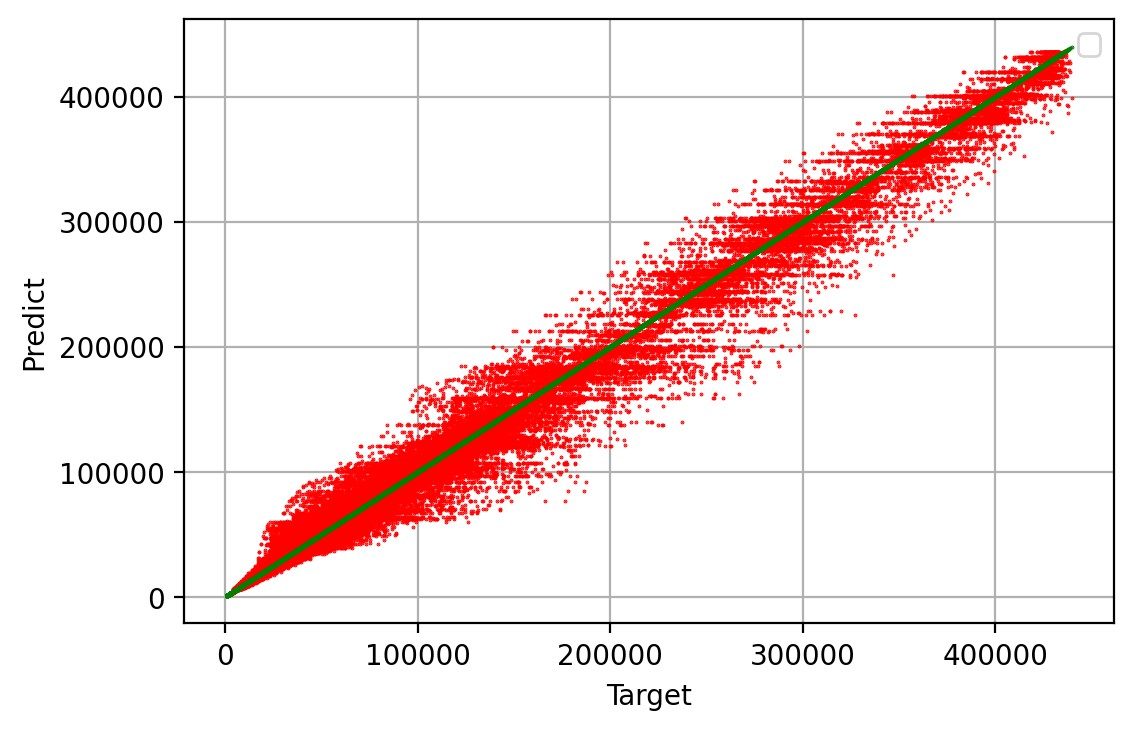

In [30]:
plt.rcParams["figure.figsize"] = (6,4)
plt.rcParams["figure.dpi"]     = 200

plt.figure(1)
plt.ylabel("Predict")
plt.xlabel("Target")


plt.plot(Test_5000[:,:], Pred_5000[:,:], 'r.', ms = 0.75,)

plt.plot(Test_5000[:,:], Test_5000[:,:], 'g.', ms = 0.75,)


plt.legend(loc='best')
plt.grid()
#plt.savefig("./Results_combineAB.png",dpi=300, bbox_inches='tight' )

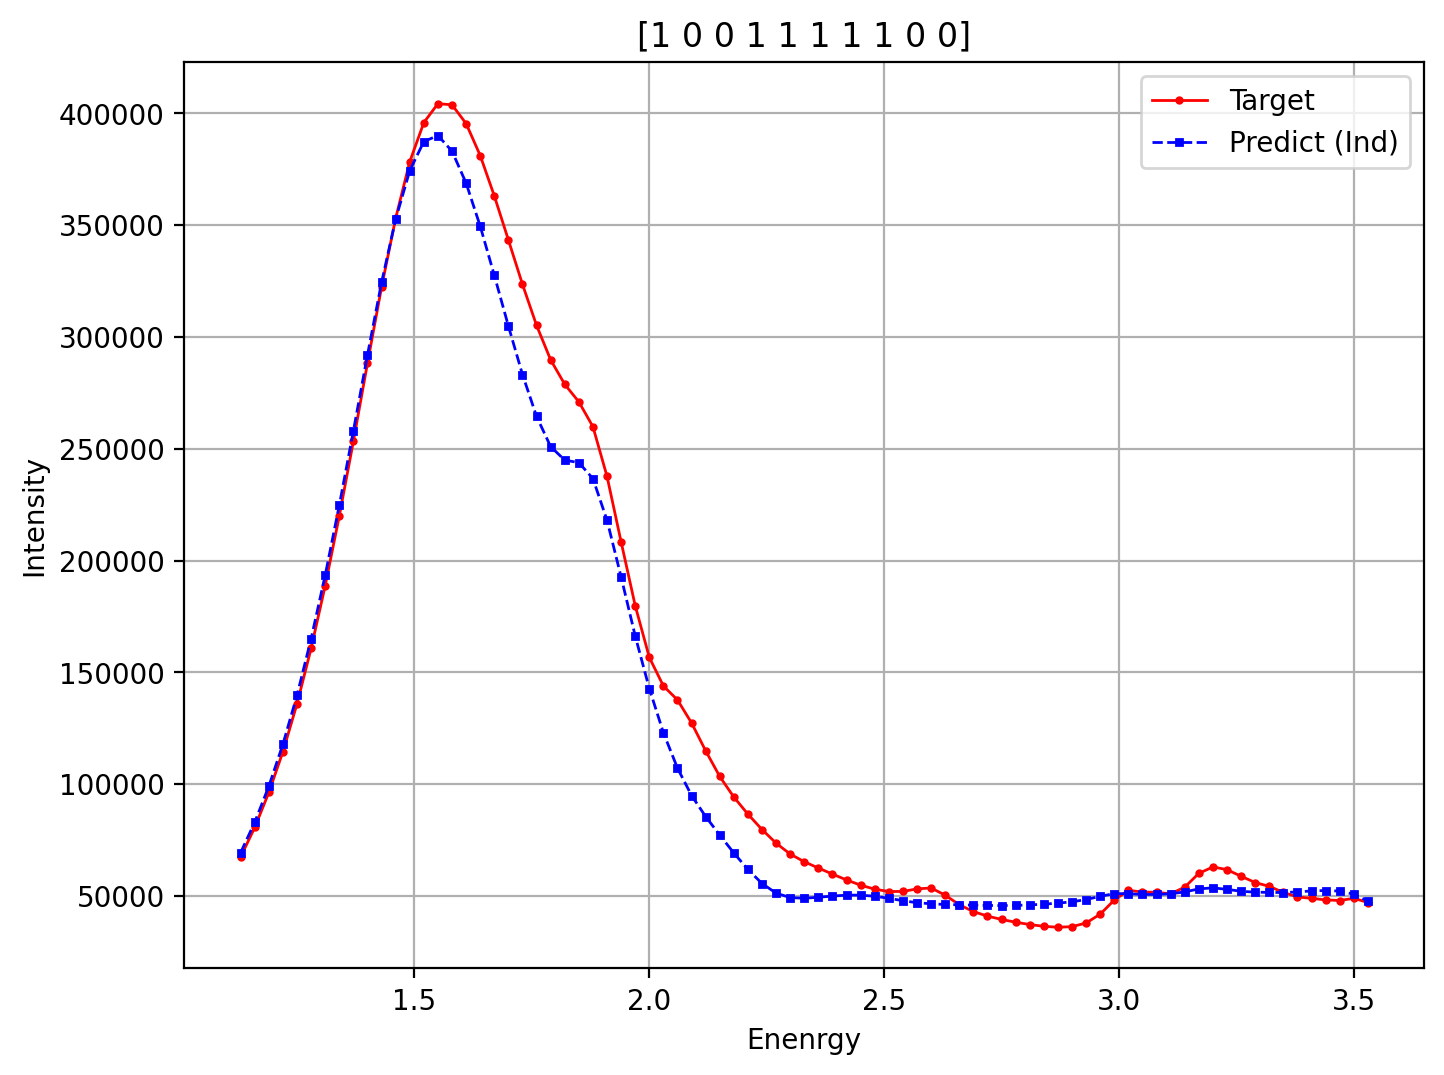

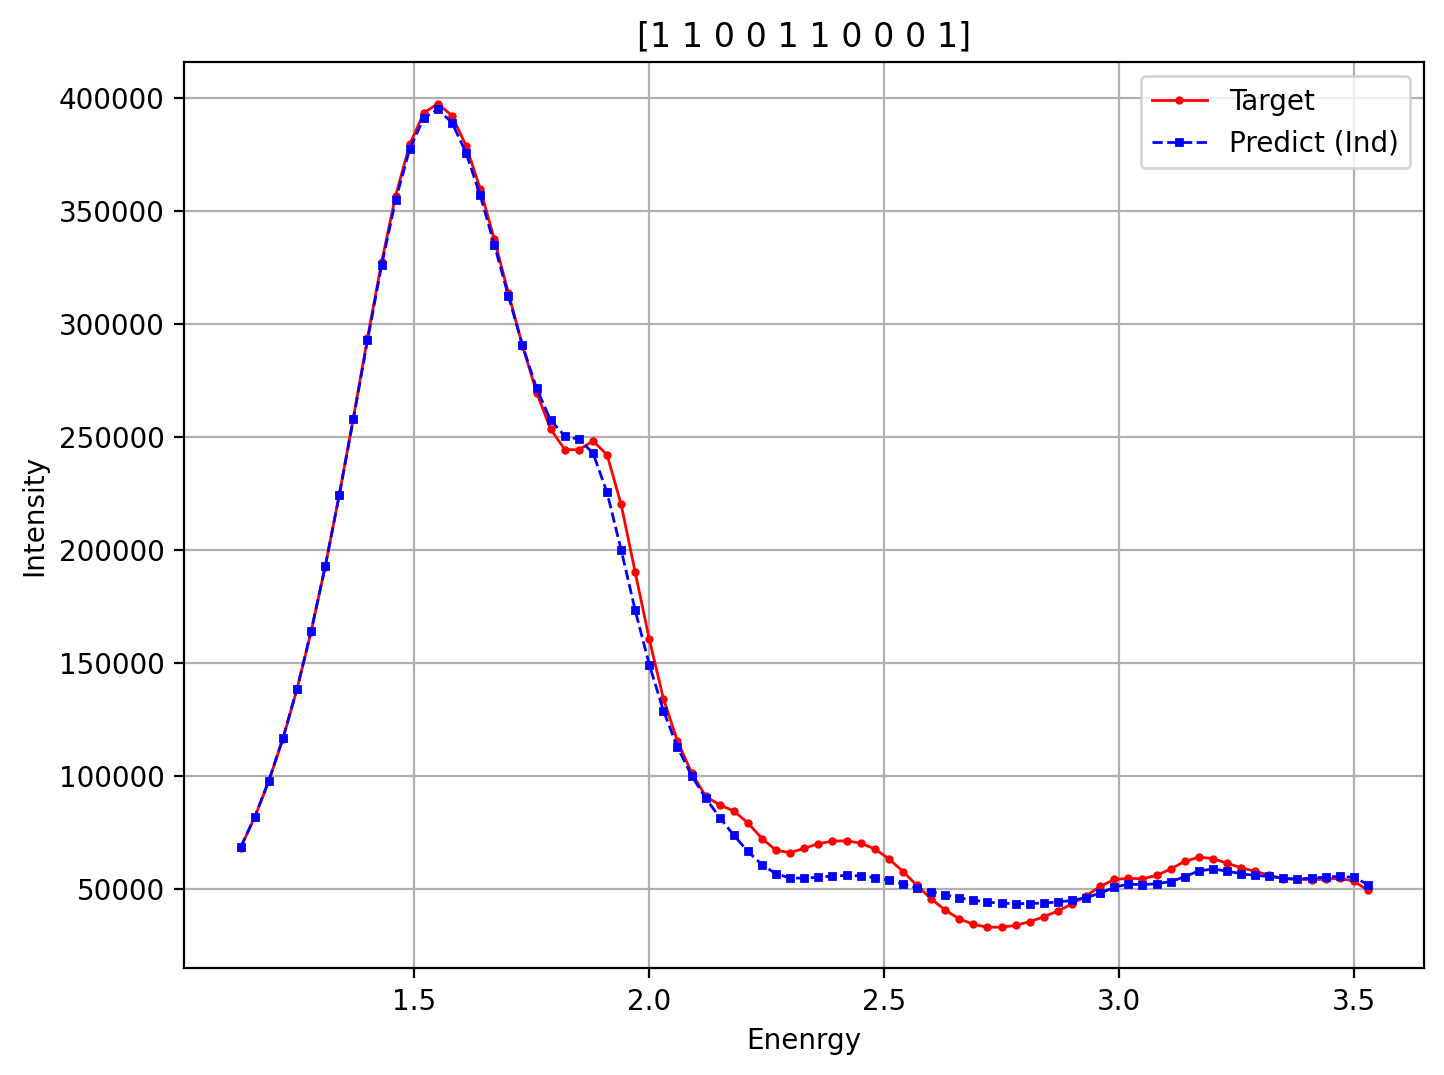

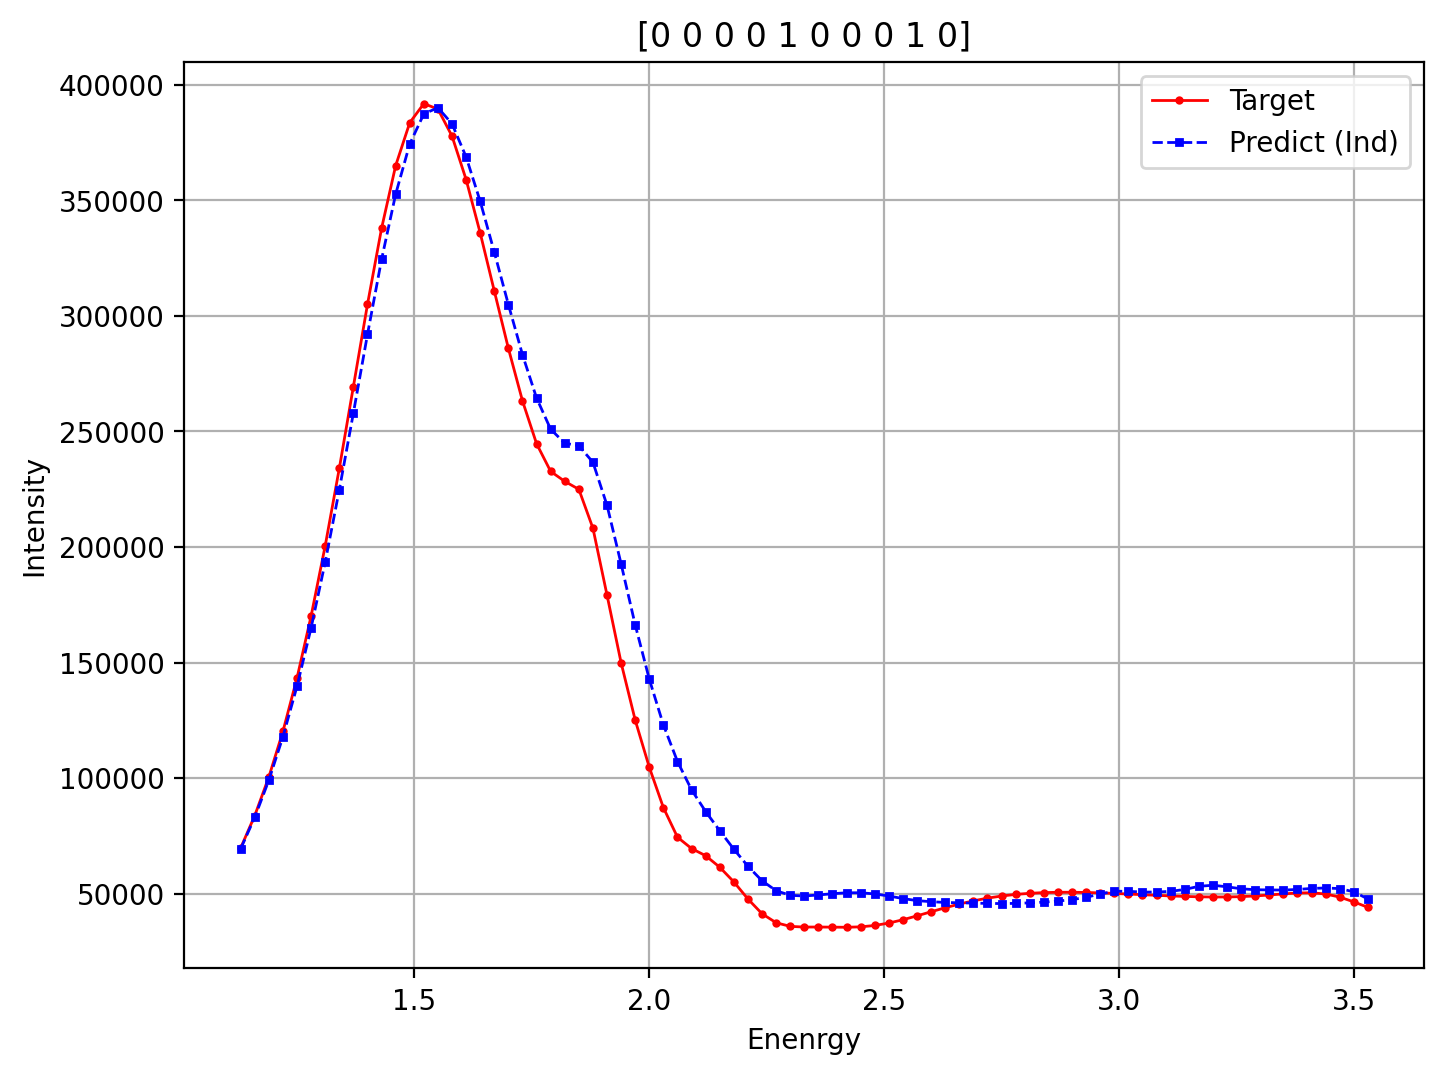

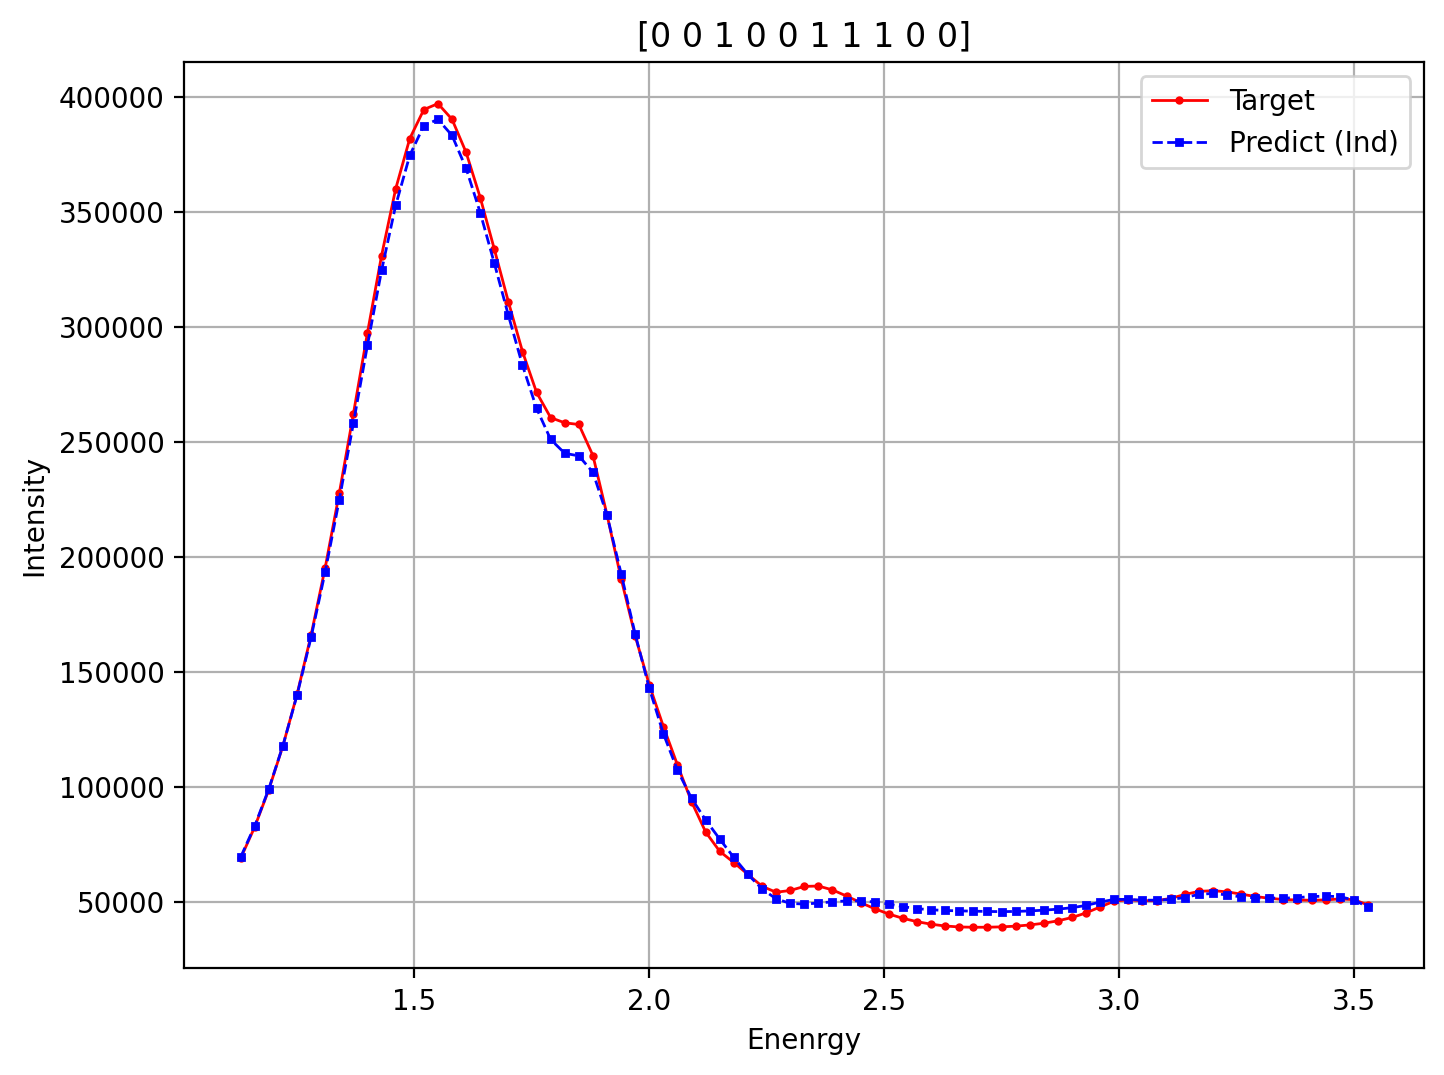

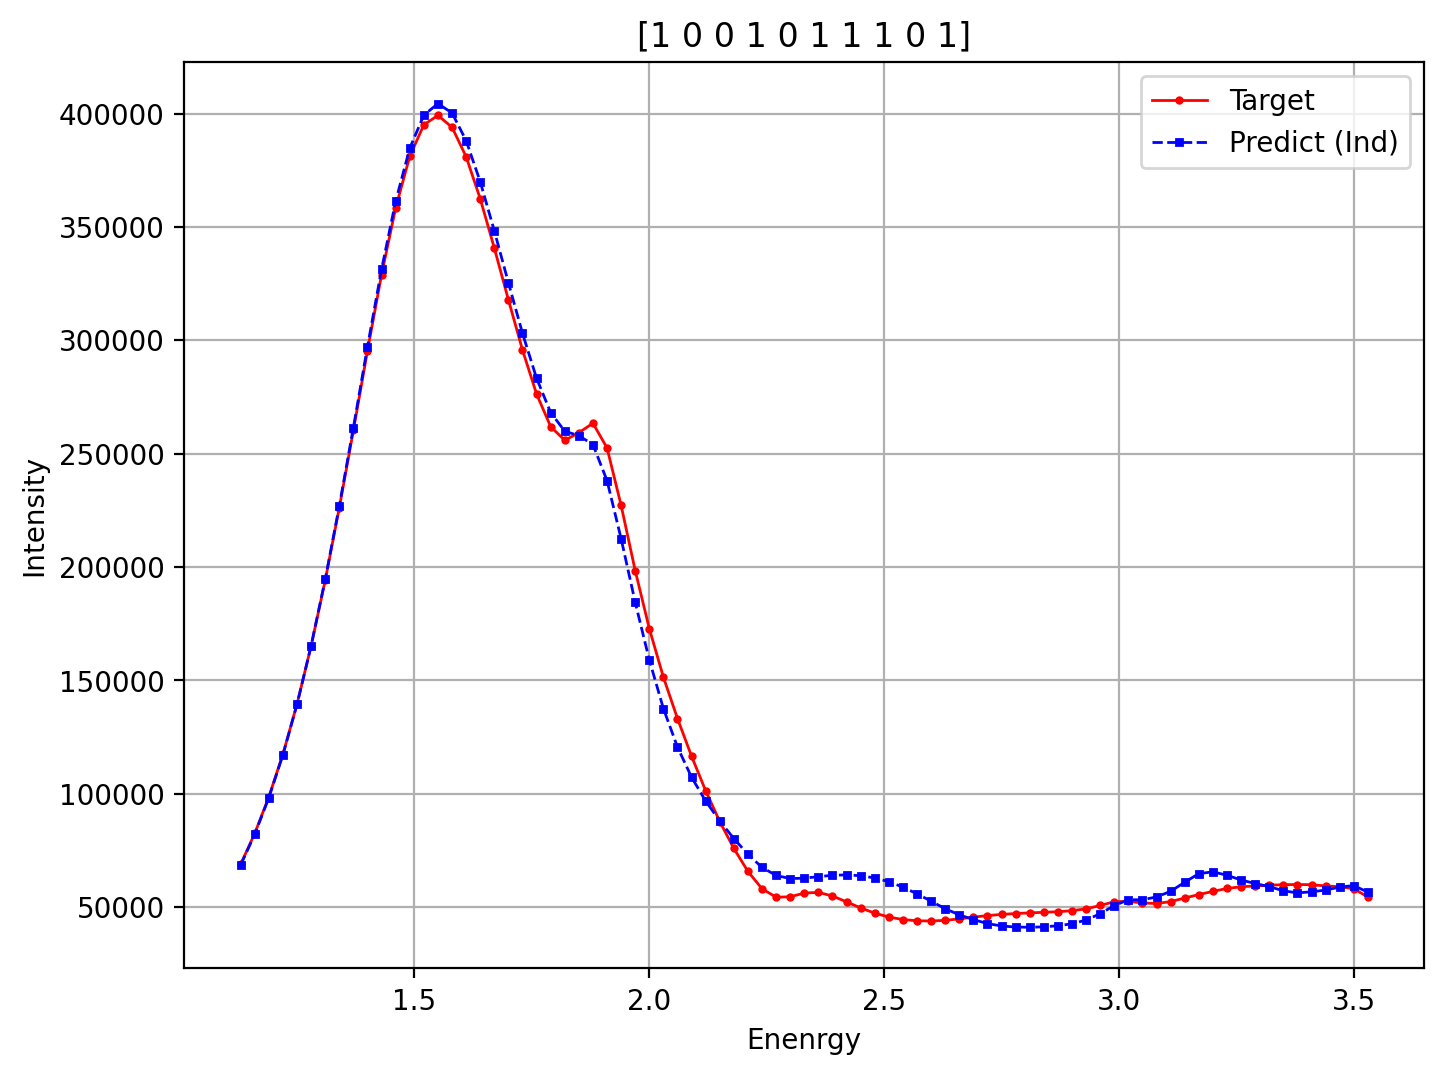

In [31]:
norm = 1.0


       
for rowIndex in range(0,250,50):
        #plt.plot(h[:,0],np.sqrt(h[:,1]*norm),label="Train")

        
    plt.rcParams["figure.figsize"] = (8,6)
    plt.rcParams["figure.dpi"]     = 200

    plt.figure(rowIndex)
    #plt.xscale("")
    plt.ylabel("Intensity")
    plt.xlabel("Enenrgy")        
    plt.plot(Input[:],Test_5000[rowIndex][:81]*norm, 'ro-', ms = 2., lw =1., label="Target")
    
    plt.plot(Input[:],Pred_5000[rowIndex][:81]*norm,'bs--', ms = 2., lw =1., label="Predict (Ind)")
    



    plt.legend(loc='best')
    plt.title(str(Sequence_Bool_C[rowIndex,]))
    plt.grid()
    plt.savefig("./Profiles/O1/Results_"+str(rowIndex)+".png",dpi=300 )